In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [35]:
# Constants
DEBUG = True
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
BATCHSIZE = 256
WORKERS = 4
EPOCHS = 10
LEARNING_RATE = 0.1
TRAINING_SHOW_UPDATES = 1

NOISY_SIZE = 100
NOISE_VALUE = 0.2

n = 785
m = 70000
labels_train.shape = (68000,)
values_train.shape = (784, 68000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


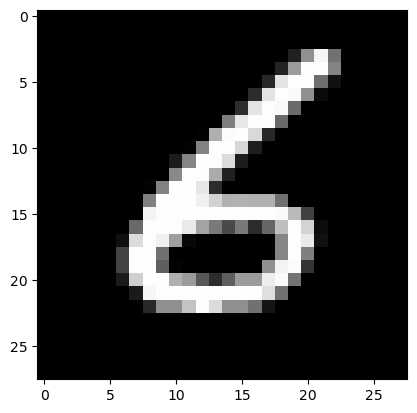

Label: 6


In [36]:
# Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

# Split data into test, validation, and training sets
data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n].astype(np.float32) / 255.0  # Normalize pixel values

data_validation = data[TEST_SIZE:(TEST_SIZE+VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n].astype(np.float32) / 255.0  # Normalize pixel values

data_train = data[(TEST_SIZE+VALIDATION_SIZE):m].T
labels_train = data_train[0]
values_train = data_train[1:n].astype(np.float32) / 255.0  # Normalize pixel values

# Extract a subset of size NOISY_SIZE from the test dataset
values_subset = values_test[:, :NOISY_SIZE]
labels_subset = labels_test[:NOISY_SIZE]


def show_image(values, index):
    """
    Display image in np format.
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

if DEBUG:
    print("n =", n)
    print("m =", m)
    print("labels_train.shape =", labels_train.shape)
    print("values_train.shape =", values_train.shape)
    print("labels_test.shape =", labels_test.shape)
    print("values_test.shape =", values_test.shape)
    show_image(values_train, 0)
    print("Label:", labels_train[0])
    

In [37]:
# Add Gaussian noise to the subset
noise = np.random.normal(0, NOISE_VALUE, values_subset.shape)
values_subset_noisy = values_subset + noise

# Clip the noisy images to ensure they remain within the valid pixel range [0, 1]
values_subset_noisy = np.clip(values_subset_noisy, 0, 1)

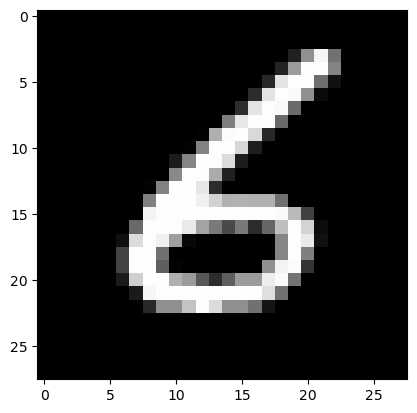

Label: 6


In [38]:
# Convert to PyTorch tensors
values_train = torch.tensor(values_train.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_train = torch.tensor(labels_train, dtype=torch.long)
dataset_train = TensorDataset(values_train, labels_train)
loader_train = DataLoader(dataset_train, batch_size=BATCHSIZE, shuffle=True, num_workers=WORKERS)

values_validation = torch.tensor(values_validation.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_validation = torch.tensor(labels_validation, dtype=torch.long)
dataset_validation = TensorDataset(values_validation, labels_validation)
loader_validation = DataLoader(dataset_validation, batch_size=BATCHSIZE, shuffle=False, num_workers=WORKERS)

values_test = torch.tensor(values_test.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_test = torch.tensor(labels_test, dtype=torch.long)
dataset_test = TensorDataset(values_test, labels_test)
loader_test = DataLoader(dataset_test, batch_size=BATCHSIZE, shuffle=False, num_workers=WORKERS)

values_subset_noisy_tensor = torch.tensor(values_subset_noisy.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_subset_tensor = torch.tensor(labels_subset, dtype=torch.long)
dataset_noisy = TensorDataset(values_subset_noisy_tensor, labels_subset_tensor)
loader_noisy = DataLoader(dataset_noisy, batch_size=256, shuffle=False)

if DEBUG:
    # show image after np -> tensor conversion
    sample_idx = 0
    plt.imshow(values_train[sample_idx].squeeze(), cmap="gray")
    plt.show()
    print("Label:", labels_train[sample_idx].item())


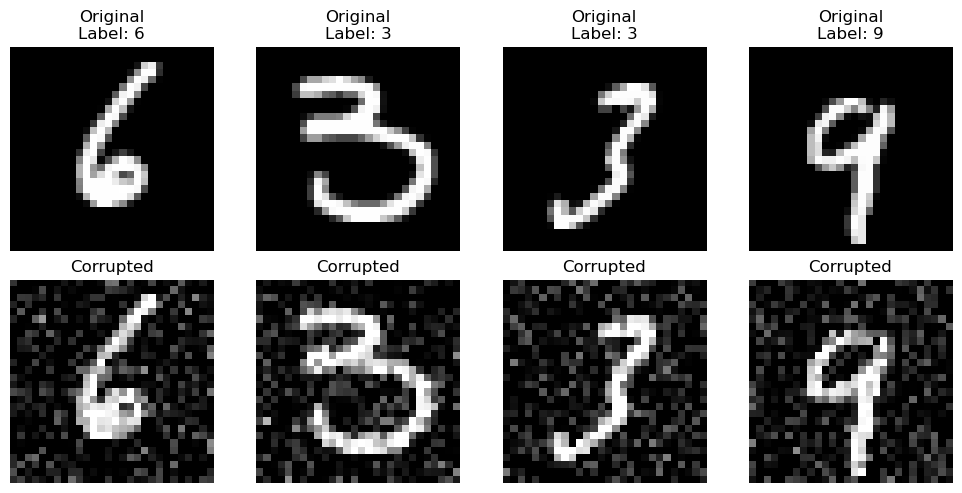

In [39]:
# Visualize four samples of original and corrupted images

num_samples = 4
plt.figure(figsize=(10, 5))

for i in range(num_samples):
    # Original image
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(values_subset[:, i].reshape(28, 28), cmap="gray")
    plt.title(f"Original\nLabel: {labels_subset[i]}")
    plt.axis("off")

    # Corrupted image
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(values_subset_noisy[:, i].reshape(28, 28), cmap="gray")
    plt.title("Corrupted")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
class Autoencoder_FCN_simple(nn.Module):
    def __init__(self):
        super(Autoencoder_FCN_simple, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  
            nn.ReLU(),
            nn.Linear(128, 64),       
            nn.ReLU(),
            nn.Linear(64, 16),  # Bottleneck layer
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()    # Ensure output is in [0,1]
        )
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)

Epoch [0/10], Train Loss: 0.231, Validation Loss: 0.229


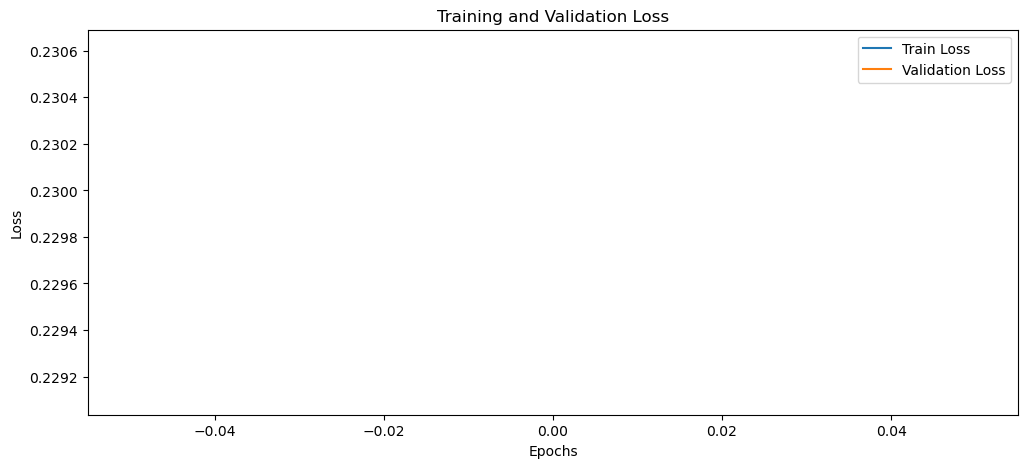

Epoch [1/10], Train Loss: 0.228, Validation Loss: 0.226


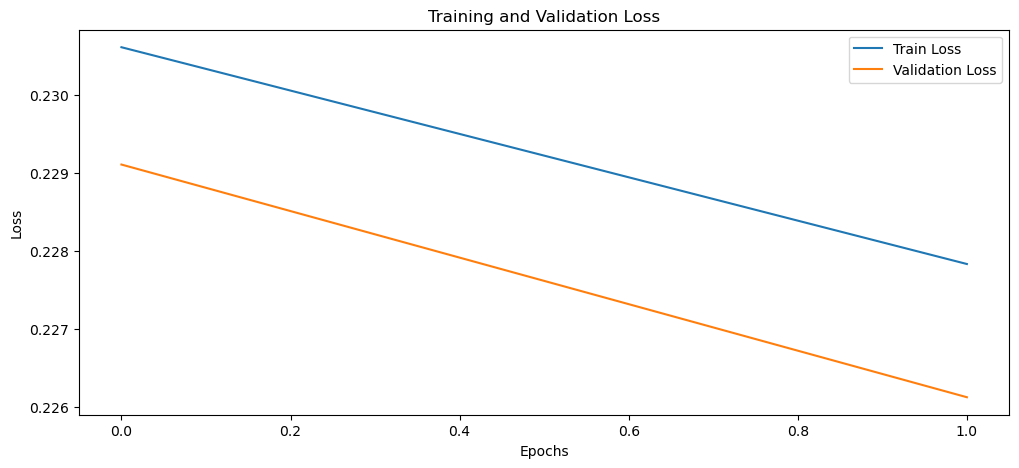

Epoch [2/10], Train Loss: 0.224, Validation Loss: 0.222


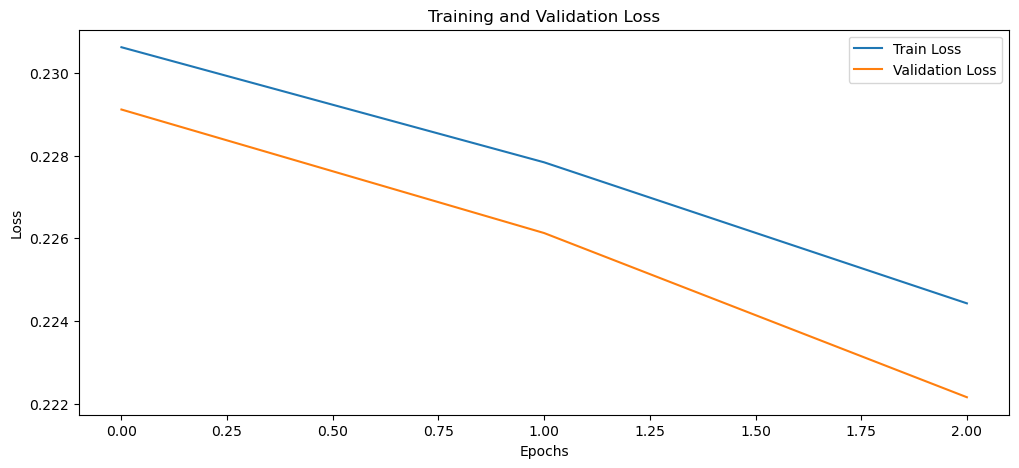

Epoch [3/10], Train Loss: 0.219, Validation Loss: 0.216


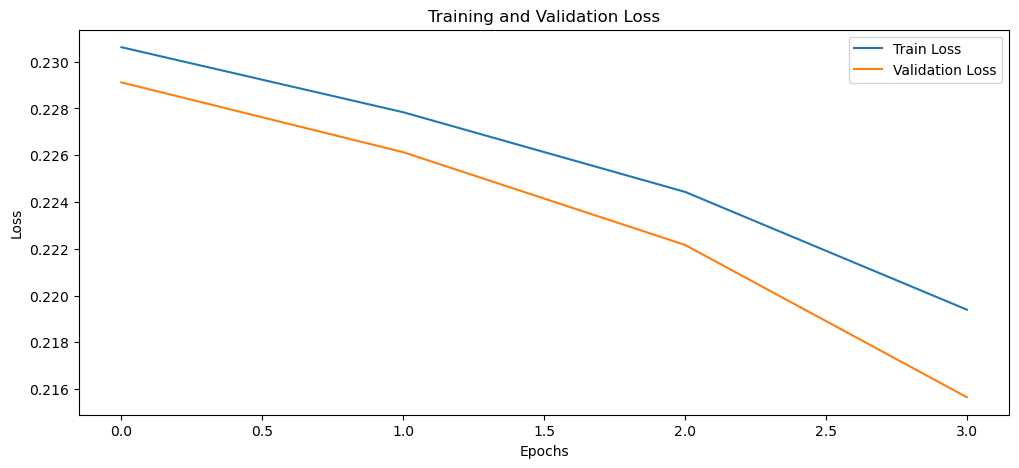

Epoch [4/10], Train Loss: 0.209, Validation Loss: 0.200


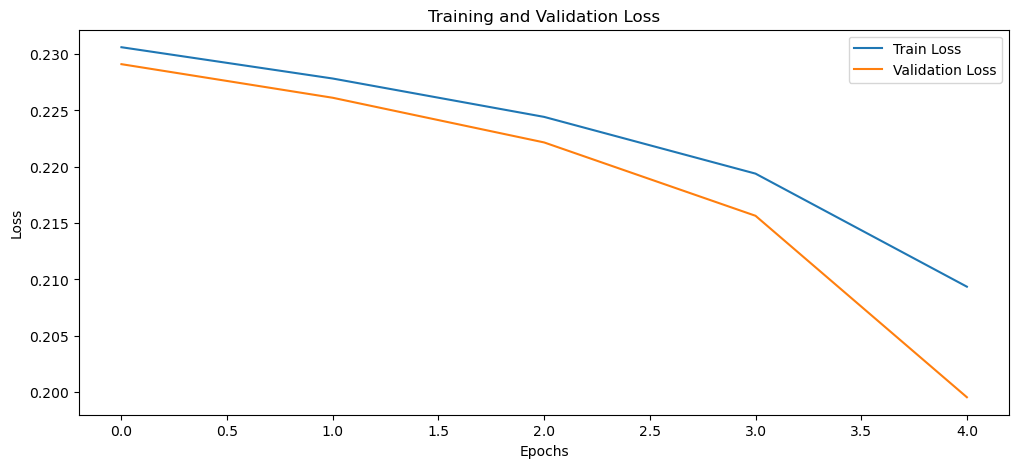

Epoch [5/10], Train Loss: 0.169, Validation Loss: 0.124


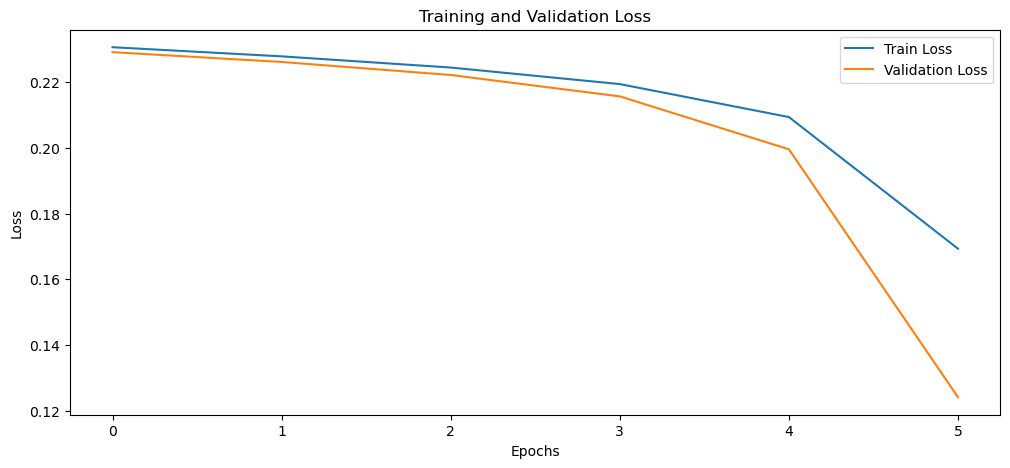

Epoch [6/10], Train Loss: 0.093, Validation Loss: 0.077


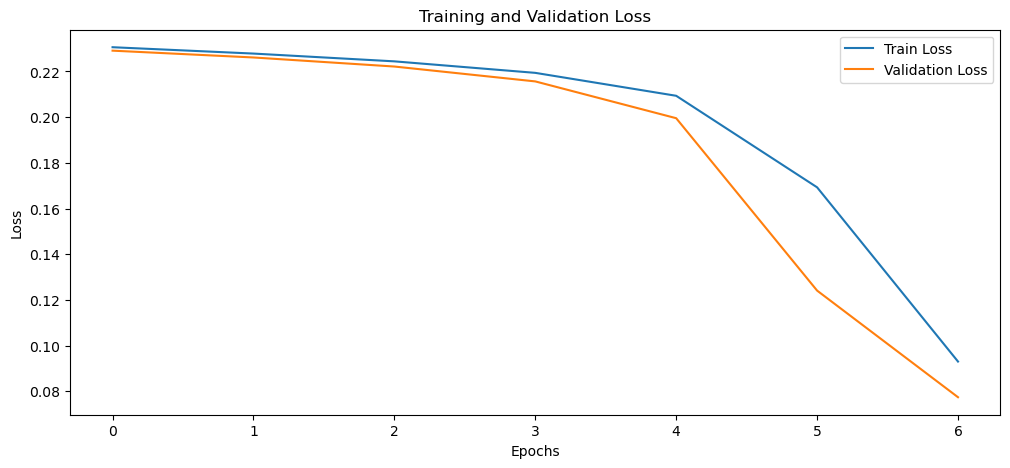

Epoch [7/10], Train Loss: 0.073, Validation Loss: 0.071


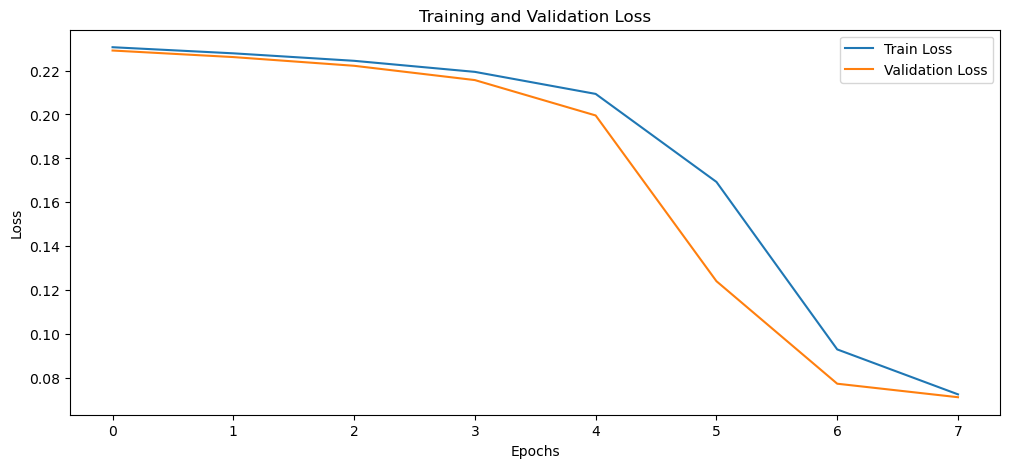

Epoch [8/10], Train Loss: 0.069, Validation Loss: 0.070


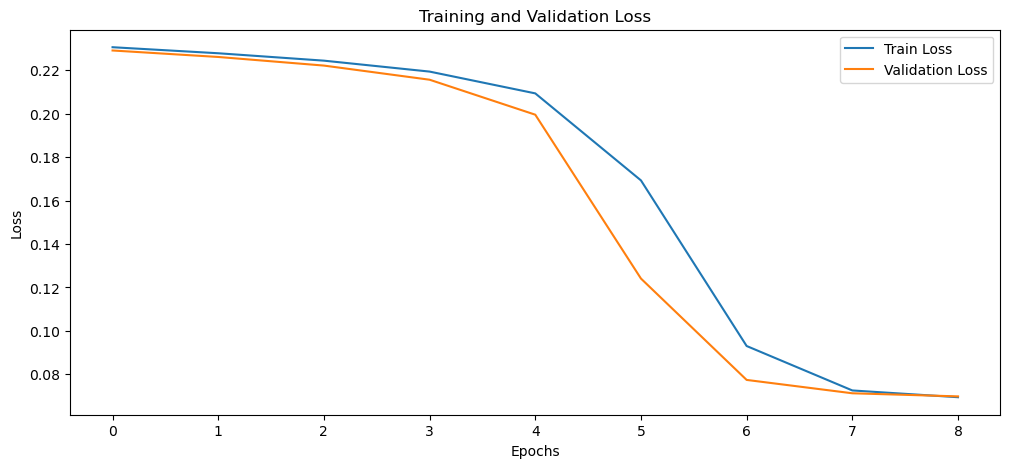

Epoch [9/10], Train Loss: 0.069, Validation Loss: 0.069


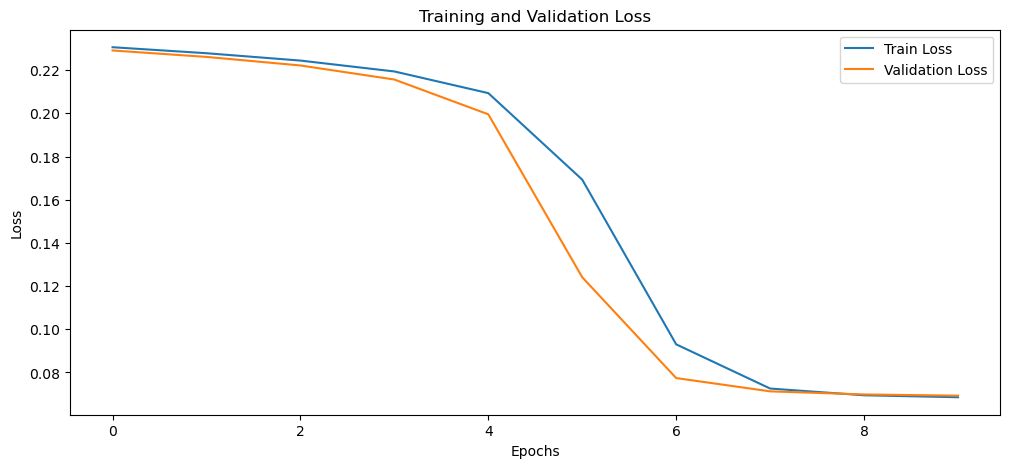

Training Time: 181.75 seconds


In [ ]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
model = Autoencoder_FCN_simple().to(device)  # Use the simplified model
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE) # SGD OPTIMIZER

loss_train_history = []
loss_validation_history = []

start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (images, _) in enumerate(loader_train):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(loader_train)
    loss_train_history.append(epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in loader_validation:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()

    val_loss /= len(loader_validation)
    loss_validation_history.append(val_loss)

    # Print training progress
    if epoch % TRAINING_SHOW_UPDATES == 0:
        print(f"Epoch [{epoch}/{EPOCHS}], Train Loss: {epoch_loss:.3f}, Validation Loss: {val_loss:.3f}")
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))
        plt.plot(loss_train_history, label="Train Loss")
        plt.plot(loss_validation_history, label="Validation Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

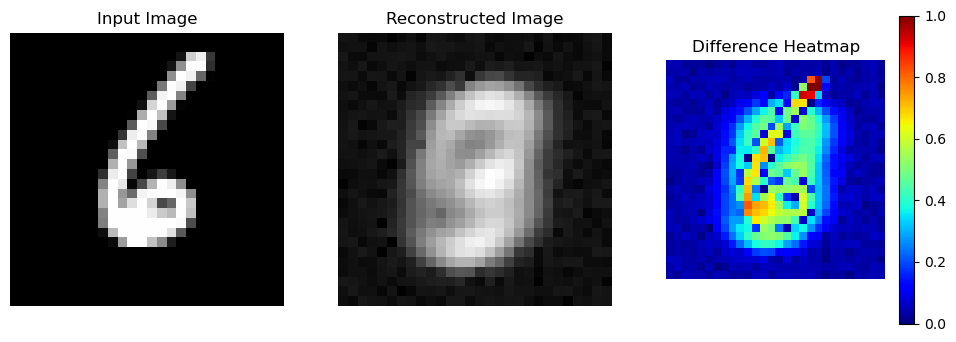

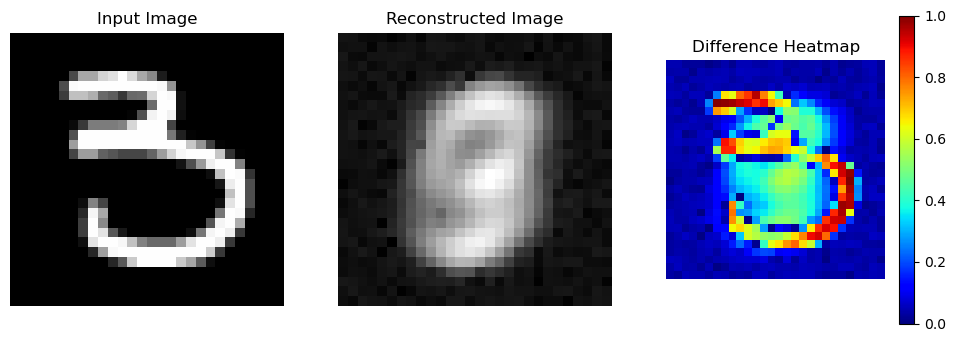

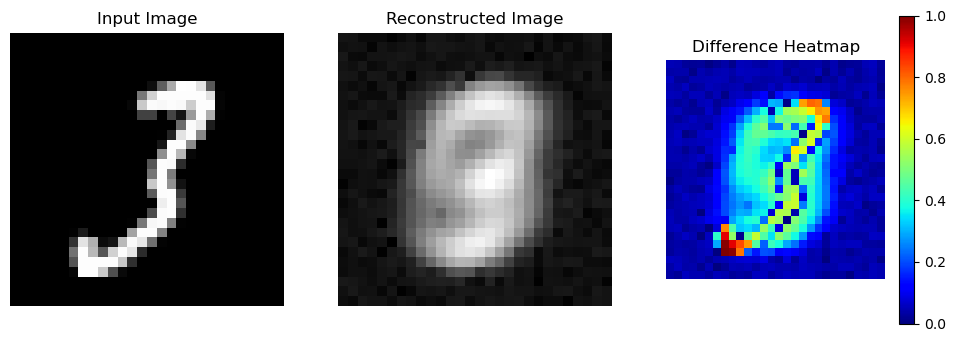

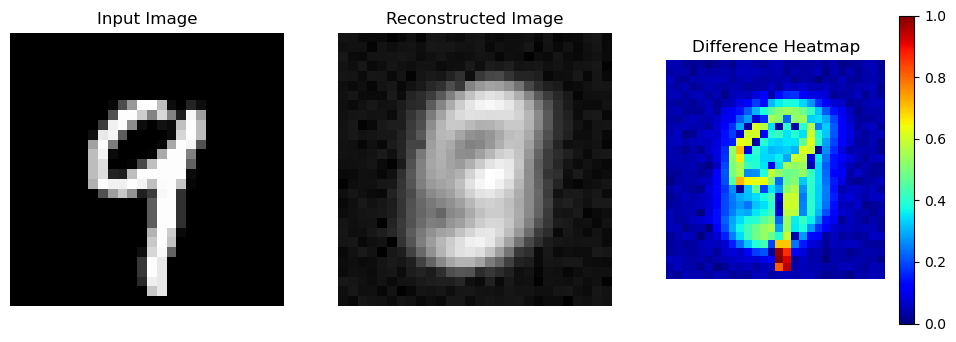

Test Loss: 0.068


In [40]:
def evaluate(loader, num_images=4):
    """Evaluate the model's reconstruction performance and highlight input-output differences."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()

            if i == 0:  # Only visualize for the first batch
                for j in range(min(num_images, images.size(0))):
                    input_image = images[j].cpu().squeeze().numpy()
                    output_image = outputs[j].cpu().squeeze().numpy()
                    difference_image = np.abs(input_image - output_image)

                    # Normalize difference for better visualization
                    diff_normalized = (difference_image - difference_image.min()) / (difference_image.max() - difference_image.min() + 1e-8)

                    # Apply a colormap to enhance contrast
                    plt.figure(figsize=(12, 4))

                    plt.subplot(1, 3, 1)
                    plt.imshow(input_image, cmap="gray")
                    plt.title("Input Image")
                    plt.axis("off")

                    plt.subplot(1, 3, 2)
                    plt.imshow(output_image, cmap="gray")
                    plt.title("Reconstructed Image")
                    plt.axis("off")

                    plt.subplot(1, 3, 3)
                    plt.imshow(diff_normalized, cmap="jet")  # Using a heatmap
                    plt.colorbar()  # Show intensity scale
                    plt.title("Difference Heatmap")
                    plt.axis("off")

                    plt.show()

    return total_loss / len(loader)


test_loss = evaluate(loader_test)
print(f"Test Loss: {test_loss:.3f}")

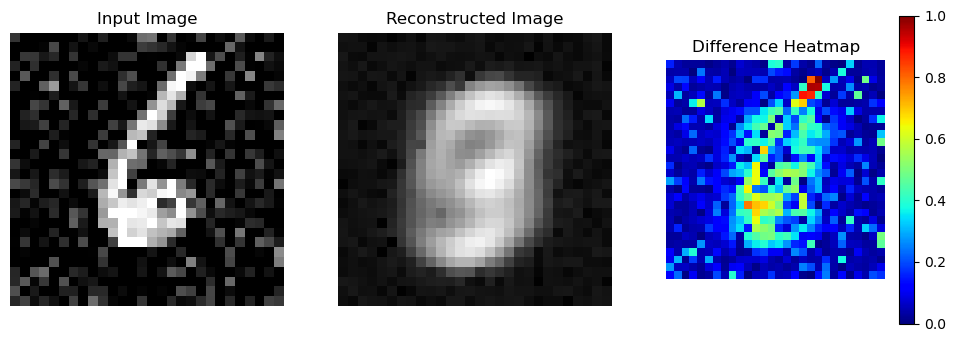

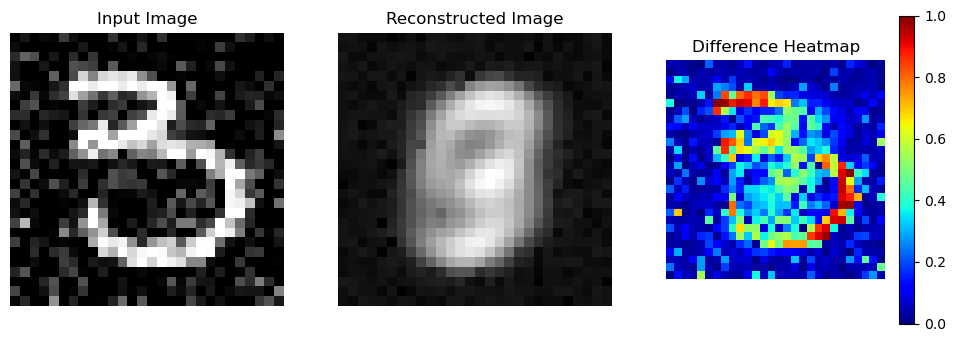

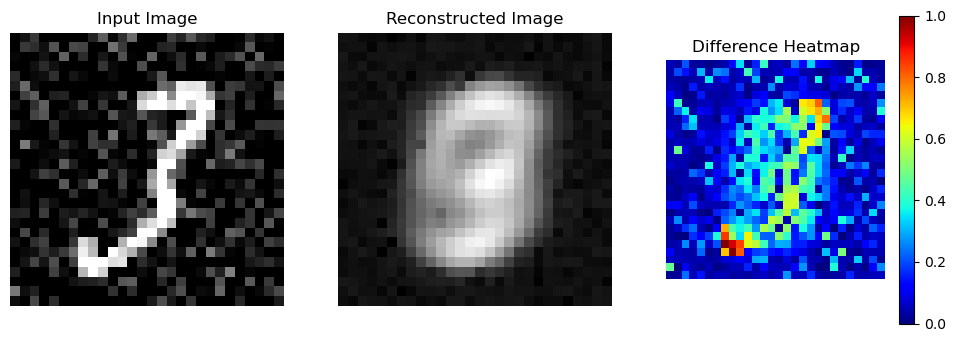

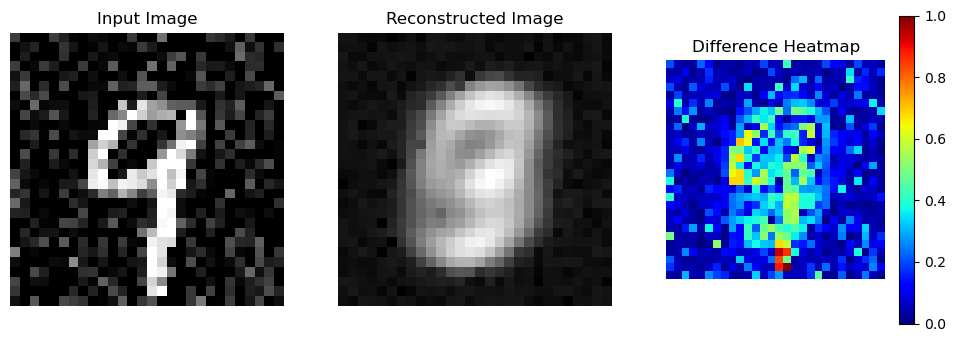

Test Loss: 0.064


In [41]:
test_loss = evaluate(loader_noisy)
print(f"Test Loss: {test_loss:.3f}")